# Comparison of MoDL and VarNet on the Stanford Fully-sampled 3D FSE Knee Dataset

This notebook evaluates and compares the reconstruction performance of **MoDL** and **VarNet** on the **Stanford Fully-sampled 3D FSE Knee 2019 dataset**.
For downloading and more information of the dataset, please refer to http://mridata.org/list?project=Stanford%20Fullysampled%203D%20FSE%20Knees.
All implementations in this notebook are based on the official **ATOMMIC** project.

## Environment Setup and Reproducibility

This notebook is built on the official ATOMMIC framework:
[https://github.com/wdika/atommic](https://github.com/wdika/atommic)

To reproduce all experiments in this notebook, please follow the steps below in your terminal:

```bash
conda create -n atommic python=3.10
conda activate atommic

git clone https://github.com/wdika/atommic
cd atommic
bash ./reinstall.sh
```

After installation, place this notebook in the following directory:

```
./atommic/projects/REC/StanfordKnees2019/
```

This ensures that all dataset paths, configuration files, and pretrained model checkpoints can be correctly accessed by the notebook.

In [87]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from atommic.collections.common.parts.transforms import EstimateCoilSensitivityMaps
from atommic.collections.common.parts import utils
import ismrmrd
from tqdm import tqdm
from atommic.collections.common.data.subsample import create_masker
from atommic.collections.common.parts import fft

## Visualization of Raw Data

To qualitatively inspect the dataset, we first visualize the fully sampled reference images before any undersampling or reconstruction. images are reconstructed from the fully sampled 8-coil k-space data using two standard coil combination methods: **Root-Sum-of-Squares (RSS)** and **SENSE-based coil combination**.

This visualization serves two main purposes. First, it allows us to verify the integrity and quality of the raw dataset. Second, it provides a clear baseline for later comparison with undersampled and reconstructed results from MoDL and VarNet.

For each 3D volume, representative slices are extracted and displayed after magnitude computation and intensity normalization.

The fully sampled images reconstructed by both RSS and SENSE methods exhibit sharp anatomical structures, clear cartilage boundaries, and low noise levels, which confirms the high quality of this dataset and its suitability as a reliable ground-truth reference for accelerated MRI reconstruction.

In [7]:
filename = '/Users/zzyc/Desktop/BENG_280/Proj2/raw_data/52c2fd53-d233-4444-8bfd-7c454240d314.h5'

In [ ]:
def ismrmrd_to_np(filename):
    """
    Read ISMRMRD data file to numpy array.

    Taken from https://github.com/iasonsky/meddlr/blob/main/datasets/format_mridata_org.py

    Parameters
    ----------
    filename : str
        The path to the ISMRMRD file.

    Returns
    -------
    kspace : np.ndarray
        The k-space data.
    """
    dataset = ismrmrd.Dataset(filename, create_if_needed=False)
    header = ismrmrd.xsd.CreateFromDocument(dataset.read_xml_header())
    num_kx = header.encoding[0].encodedSpace.matrixSize.x
    num_ky = header.encoding[0].encodingLimits.kspace_encoding_step_1.maximum
    num_slices = header.encoding[0].encodingLimits.slice.maximum + 1
    num_channels = header.acquisitionSystemInformation.receiverChannels

    try:
        rec_std = dataset.read_array("rec_std", 0)
        rec_weight = 1.0 / (rec_std**2)
        rec_weight = np.sqrt(rec_weight / np.sum(rec_weight))
        print("Using rec std...")
    except Exception:
        rec_weight = np.ones(num_channels)
    opt_mat = np.diag(rec_weight)
    kspace = np.zeros([num_channels, num_slices, num_ky, num_kx], dtype=np.complex64)
    num_acq = dataset.number_of_acquisitions()

    for i in tqdm(range(num_acq)):
        acq = dataset.read_acquisition(i)
        i_ky = acq.idx.kspace_encode_step_1  # pylint: disable=no-member
        i_slice = acq.idx.slice  # pylint: disable=no-member
        data = np.matmul(opt_mat.T, acq.data)
        kspace[:, i_slice, i_ky, :] = data * ((-1) ** i_slice)

    dataset.close()

    return kspace.astype(np.complex64)

In [8]:
kspace = ismrmrd_to_np(filename)

Using rec std...


100%|██████████| 81920/81920 [00:56<00:00, 1453.15it/s]


In [9]:
print(type(kspace))
print(kspace.dtype)
print(kspace.shape)

<class 'numpy.ndarray'>
complex64
(8, 256, 320, 320)


In [10]:
imspace = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(kspace, axes=(-2, -1)), axes=(-2, -1)), axes=(-2, -1))
target_rss = torch.view_as_complex(utils.coil_combination_method(utils.to_tensor(imspace), torch.empty([]), "RSS"))

In [11]:
csm_estimator = EstimateCoilSensitivityMaps(
    coil_sensitivity_maps_type="rss",
    gaussian_sigma=0.0,
    espirit_threshold=0.05,
    espirit_kernel_size=6,
    espirit_crop=0.95,
    espirit_max_iters=30,
    fft_centered=True,
    fft_normalization="ortho",
    spatial_dims=[1, 2],
    coil_dim=0,
)

In [12]:
kspace_1 = utils.to_tensor(kspace)

In [13]:
print(type(kspace_1))
print(kspace_1.dtype)
print(kspace_1.shape)

<class 'torch.Tensor'>
torch.float32
torch.Size([8, 256, 320, 320, 2])


In [14]:
sensitivity_map = torch.stack([csm_estimator(kspace_1[:, slice_idx]) for slice_idx in range(kspace_1.shape[1])], 1)

In [15]:
target_sense = torch.view_as_complex(utils.coil_combination_method(utils.to_tensor(imspace), sensitivity_map, "SENSE"))

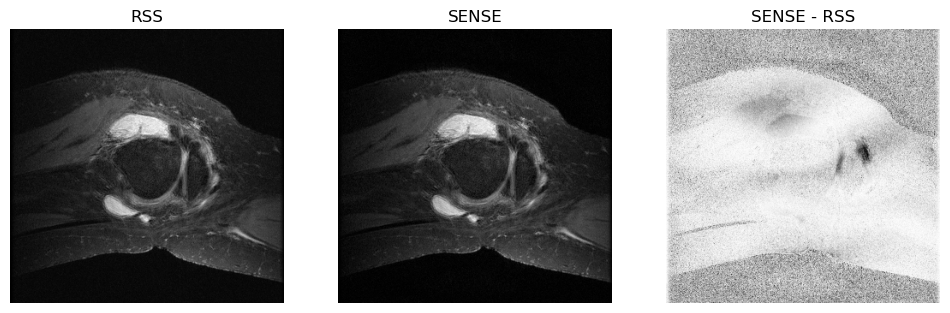

In [125]:
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.imshow(torch.abs(target_rss[80]), cmap='gray')
plt.title('RSS')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(torch.abs(target_sense[80]), cmap='gray')
plt.title('SENSE')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(torch.abs(target_sense[80]) - torch.abs(target_rss[80]), cmap='gray')
plt.title('SENSE - RSS')
plt.axis('off')
plt.show()

## Data Preprocessing

The raw dataset is preprocessed using the preprocessing script provided in the ATOMMIC project. The preprocessing is executed via the following terminal command:

```bash
bash ./projects/REC/StanfordKnees2019/preprocess_dataset.sh
```

During execution, the script prompts the user to specify:

* The directory containing the raw dataset,
* And the output directory for the processed data.

The preprocessing pipeline performs the following operations:

* The raw data are converted from **ISMRMRD** format to **HDF5** format to enable efficient loading and processing in the reconstruction pipeline.

* The dataset is randomly split into:

  * 70% for training,
  * 15% for validation,
  * 15% for testing.

## Undersampling with Gaussian 2D Mask (12× Acceleration)

To simulate accelerated MRI acquisition, we apply a **2D Gaussian undersampling mask with an acceleration factor of 12×** to the fully sampled k-space data.

The Gaussian sampling strategy preserves a higher sampling density near the k-space center and gradually reduces sampling toward the high-frequency regions. This design follows the energy distribution of MRI signals and helps maintain low-frequency structural information while enabling strong acceleration.

This 12× acceleration setting represents a highly challenging reconstruction scenario and is used to rigorously evaluate the robustness and performance of both **MoDL** and **VarNet** under severe undersampling conditions.

In [115]:
# initialize general parameters for transformations (same as the ones used in .yaml file)
fft_centered = True
fft_normalization = 'ortho'
spatial_dims = [-2, -1]
coil_dim = 0

In [116]:
# initialize the undersampling masker
masker = create_masker('gaussian2d', 0.7, 12)
# apply the masker
masked_kspace, mask, acc = utils.apply_mask(kspace_1, masker, center_scale=0.02)
# apply the IFFT
masked_imspace = fft.ifft2(masked_kspace, fft_centered, fft_normalization, spatial_dims)
# normalize the image for consistent visualization
masked_imspace = masked_imspace / torch.max(torch.abs(masked_imspace))
# compute the RSS target
masked_imspace_rss_target = utils.rss_complex(masked_imspace, coil_dim)

## Training and Testing Preparation

To perform inference and evaluation using pretrained models, the configuration files **`modl.yaml`** and **`varnet.yaml`** are first modified to specify the paths to the **Hugging Face pretrained checkpoints**. In addition, the corresponding **training and testing parameters**, including dataset paths and output directories, are updated accordingly.

After updating the configuration files, the reconstruction experiments are launched using the following terminal commands:

```bash
atommic run -c /projects/REC/StanfordKnees2019/conf/test/modl.yaml
atommic run -c /projects/REC/StanfordKnees2019/conf/test/varnet.yaml
```

During execution, the program prompts the user to input:

* The directory of the testing dataset,
* And the directory where the reconstructed results will be saved.

## Format Conversion of Reconstructed Data

In [120]:
h5_path = "/Users/zzyc/Desktop/BENG_280/Proj2/test_results/modl_12x/default/2025-12-03_21-38-54/reconstructions/52c2fd53-d233-4444-8bfd-7c454240d314.h5"
with h5py.File(h5_path, "r") as f:
    modl_recon = f["reconstruction"][:]

modl_recon = torch.tensor(modl_recon)

if modl_recon.ndim == 4:
    modl_recon = modl_recon.squeeze(1)

modl_recon = modl_recon / torch.max(torch.abs(modl_recon))
print("MoDL recon shape:", modl_recon.shape)

MoDL recon shape: torch.Size([256, 320, 320])


In [121]:
h5_path = "/Users/zzyc/Desktop/BENG_280/Proj2/varnet_test_results/default/2025-12-04_01-26-35/reconstructions/52c2fd53-d233-4444-8bfd-7c454240d314.h5"
with h5py.File(h5_path, "r") as f:
    var_recon = f["reconstruction"][:]

var_recon = torch.tensor(var_recon)

if var_recon.ndim == 4:
    var_recon = var_recon.squeeze(1)

var_recon = var_recon / torch.max(torch.abs(var_recon))
print("Varnet recon shape:", var_recon.shape)

Varnet recon shape: torch.Size([256, 320, 320])


## Visualization Comparison

Figure 2 on Slide 12 generated here


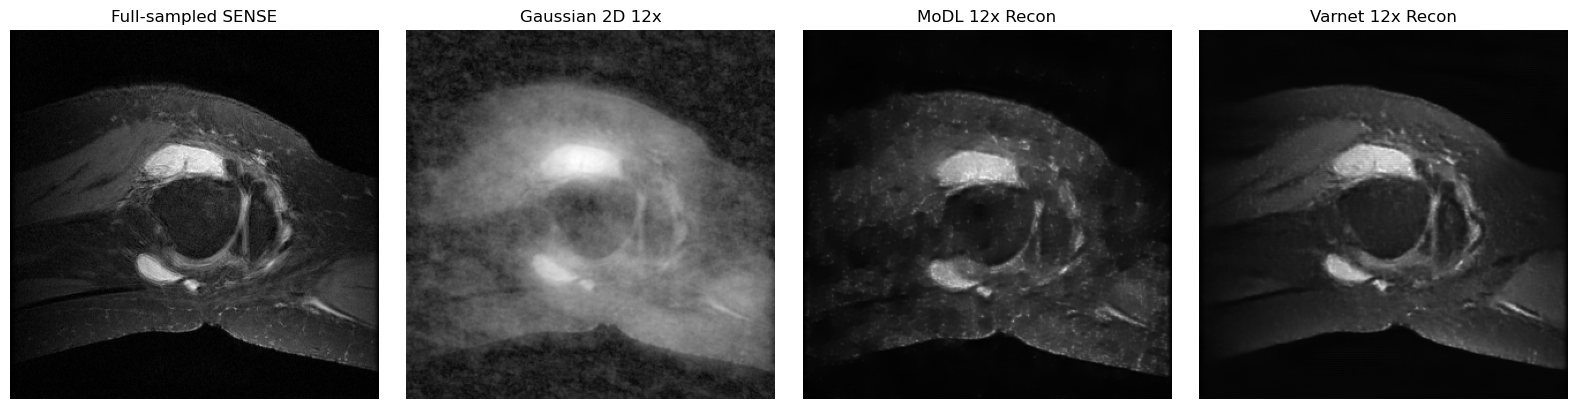

In [131]:
plt.figure(figsize=(16,4))

plt.subplot(1, 4, 1)
plt.imshow(torch.abs(target_sense[80]), cmap='gray')
plt.title('Full-sampled SENSE')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(masked_imspace_rss_target[80], cmap='gray')
plt.title('Gaussian 2D 12x')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(torch.abs(modl_recon[80]), cmap="gray")
plt.title("MoDL 12x Recon")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(torch.abs(var_recon[80]), cmap="gray")
plt.title("Varnet 12x Recon")
plt.axis("off")

print("Figure 2 on Slide 12 generated here")
plt.tight_layout()
plt.show()



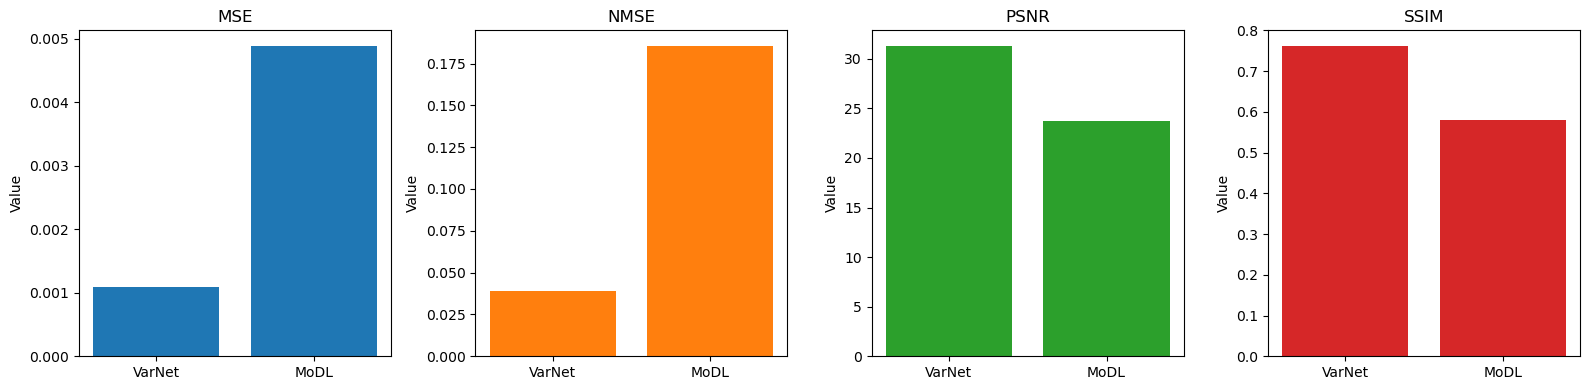

In [129]:
metrics = ["MSE", "NMSE", "PSNR", "SSIM"]
varnet = [0.001094972132705152, 0.038835786283016205, 31.310178756713867, 0.7622873783111572]
modl   = [0.004888545256108046, 0.18556331098079681, 23.732162475585938, 0.5811567306518555]

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, ax in enumerate(axes):
    ax.bar(["VarNet", "MoDL"], [varnet[i], modl[i]], color=colors[i])
    ax.set_title(metrics[i])
    ax.set_ylabel("Value")

plt.tight_layout()
plt.show()

